In [1]:
import cv2
import numpy as np
import scipy as scp
import matplotlib
print matplotlib.rcParams['figure.figsize']
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
import matplotlib.pyplot as plt
import math

[6.4, 4.8]


In [2]:
def drawRect(img, rect):
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img,[box],0,(0,255,0),2)
    
def minmax(a, b):
    return (a, b) if a < b else (b, a)

def show(img_obj):
    plt.imshow(img_obj)
    plt.show()
    
def sort_points(rect):
    x_sort = np.array(sorted(rect, key=lambda x: x[1]))
    if x_sort[0,0] > x_sort[1,0]:
        x_sort[0,0], x_sort[1,0] = swap(x_sort[0,0], x_sort[1,0])
    if x_sort[2,0] > x_sort[3,0]:
        x_sort[2,0], x_sort[3,0] = swap(x_sort[2,0], x_sort[3,0])
    return x_sort

In [3]:
class Armor:
    RED_THRESH = 50
    BLUE_THRESH = 90
    GRAY_THRESH = 200 # Official Version Set to 200
    
    LIGHT_MIN_ASPECT_RATIO = 2
    LIGHT_MAX_ANGLE = 30.0
    LIGHT_MIN_AREA = 4.0
    LIGHT_MAX_ANGLE_DIFF = 30.0
    
    ARMOR_MAX_ANGLE = 20.0
    ARMOR_MIN_AREA = 40.0
    ARMOR_MAX_ASPECT_RATIO = 3.0
    
    def __init__(self):
        pass
    
    def preprocess(self, img):
        self._img = img
        self._gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    def color_thresh(self, color):
        bgr = cv2.split(self._img)
        result = None
        if (color == 'red'):
            result = bgr[2] - bgr[1]
            thresh = self.RED_THRESH
        elif (color == 'blue'):
            result = bgr[0] - bgr[2]
            thresh = self.BLUE_THRESH
        if result is None:
            return None
        self._color_highlight = result
        ret, result = cv2.threshold(result, thresh, 255, cv2.THRESH_BINARY)
        if not ret:
            return None
        kernal = np.ones((3,3), dtype=np.uint8)
        result = cv2.dilate(result, kernal, iterations=1)
        result &= self._gray_bin
        self._light_bin = result
        return result

    def gray_thresh(self):
        ret, result = cv2.threshold(self._gray_img, self.GRAY_THRESH, 255, cv2.THRESH_BINARY)
        if not ret:
            return None
        else:
            self._gray_bin = result
            return result

    def light_detect(self, color):
        self.gray_thresh()
        self.color_thresh(color) 
        
        cnt_method = cv2.CHAIN_APPROX_NONE
        cnt_mode = cv2.RETR_EXTERNAL
        
        im1, light_cnt, hier1 = cv2.findContours(self._light_bin, cnt_mode, cnt_method)
        im2, gray_cnt, hier2 = cv2.findContours(self._gray_bin, cnt_mode, cnt_method)
 
        proc_flag = np.zeros(len(gray_cnt), dtype=bool)
        light_rects = []
        
        for i in range(len(light_cnt)):
            for j in range(len(gray_cnt)):
                if not proc_flag[j]:
                    if cv2.pointPolygonTest(gray_cnt[j], tuple(light_cnt[i][0][0]), True) >= 0.0:
                        light_rects.append(cv2.minAreaRect(gray_cnt[j]))
                        proc_flag[j] = True
                        break
        self._lights = light_rects
        return light_rects
    
    def light_filter(self):
        f_rects = []
        for rect in self._lights:
            r1 = max(rect[1][0], 1.0)
            r2 = max(rect[1][1], 1.0)
            ang = rect[2]
            asp_ratio = 1.0* max(r1, r2) / min(r1, r2)
            new_ang = abs(abs(ang)-90) if max(r1, r2) == r1 else abs(ang)
            if (asp_ratio > self.LIGHT_MIN_ASPECT_RATIO and
               new_ang < self.LIGHT_MAX_ANGLE and r1*r2 >= self.LIGHT_MIN_AREA):
                if max(r1, r2) == r2:
                    f_rects.append(rect)
                else:
                    f_rects.append((rect[0], (r2, r1), new_ang))
        self._lights = f_rects
        return f_rects
    
    def armor_detect(self):
        a_rects = []
        for i in range(len(self._lights)-1):
            for j in range(i+1, len(self._lights)):
                light1 = self._lights[i]
                light2 = self._lights[j]
                edge1 = minmax(light1[1][0], light1[1][1])
                edge2 = minmax(light2[1][0], light2[1][0])
                light_dis = math.sqrt((light1[0][0] - light2[0][0])**2 + \
                                      (light1[0][1] - light2[0][1])**2)
                bbox_ang = math.atan((light1[0][1] - light2[0][1]) / \
                                     (light1[0][0] - light2[0][0] + 1e-8)) * 180 / math.pi
                bbox_x = (light1[0][0] + light2[0][0]) / 2
                bbox_y = (light1[0][1] + light2[0][1]) / 2
                bbox_h = max(edge1[1], edge2[1]) * 2
                bbox_w = light_dis * 1.2
                bbox = ((bbox_x, bbox_y), (bbox_w, bbox_h), bbox_ang)
                if abs(light1[2] - light2[2]) < self.LIGHT_MAX_ANGLE_DIFF and \
                abs(bbox_ang) < self.ARMOR_MAX_ANGLE and \
                bbox_w / bbox_h < self.ARMOR_MAX_ASPECT_RATIO and \
                bbox_h*bbox_w > self.ARMOR_MIN_AREA:
                    a_rects.append(bbox)
        self._armor_rects = a_rects
        return a_rects
                    
                

In [4]:
armor = Armor()

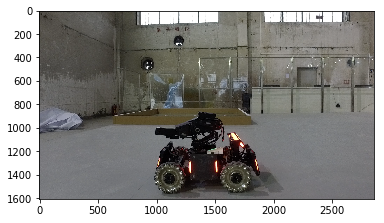

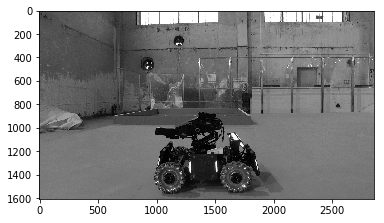

In [5]:
img = cv2.imread('./test3.png')
armor.preprocess(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(armor._gray_img, cmap='gray')
plt.show()

[[ 1270.3927002   1429.88671875]
 [ 1266.96936035  1239.91748047]
 [ 1534.79699707  1235.09130859]
 [ 1538.22033691  1425.06054688]]


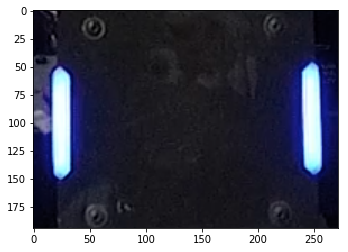

In [ ]:
l_rects = armor.light_detect('red')
#plt.imshow(armor._color_highlight, cmap='gray')
#plt.show()
#plt.imshow(armor._light_bin, cmap='gray')
#plt.show()
#l_rects = armor.light_filter(l_rects)
lights = armor.light_filter()
armors = armor.armor_detect()
#print armors

for n, rect in enumerate(armors):
    if n != 3: continue
    _box = cv2.boxPoints(rect)
    print _box
    armor_y = int(min(_box, key = lambda pt: pt[1])[1])
    armor_x = int(min(_box, key = lambda pt: pt[0])[0])
    armor_h = int(max(_box, key = lambda pt: pt[1])[1] - armor_y)
    armor_w = int(max(_box, key = lambda pt: pt[0])[0] - armor_x)
    #print rect
    #armor_h = int(rect[1][1])
    #armor_w = int(rect[1][0])
    #armor_x = int(rect[0][0] - 1.0/2 * armor_w)
    #armor_y = int(rect[0][1] - 1.0/2 * armor_y)
    plt.imshow(img[armor_y:armor_y+armor_h, armor_x:armor_x+armor_w])
    plt.show()

test_img = img[armor_y:armor_y+armor_h, armor_x:armor_x+armor_w]
#for rect in l_rects:    
pts1 = np.float32([[10,0],[15,180],[250,0]])
pts2 = np.float32([[0,0],[0,200],[260,0]])


In [ ]:
box = cv2.boxPoints(rect[3])
pts1 = sort_points(box).astype("float32")
desired_img_pts = np.array([[0, 0], [50, 0], [0, 50], [50, 50]], dtype = "float32")
M = cv2.getPerspectiveTransform(pts1, desired_img_pts)
new_img = cv2.warpPerspective(img, M, (50, 50))
show(new_img)

In [ ]:
for rect in armors:
    drawRect(img, rect)

plt.imshow(img)
plt.show()